# Regresiones

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Resultado del mes anterior

In [2]:
imacec = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/BC%20Imacec.csv', parse_dates=True, dayfirst=True, index_col='Fecha')
imacec.columns = ['imacec']
imacec.tail()

,imacec
Fecha,
2021-02-01,-2.020639
2021-03-01,6.217878
2021-04-01,14.584570
2021-05-01,19.183195
2021-06-01,20.607161


In [3]:
prediccion = pd.read_csv('pred_2021_06.csv', index_col=0)
prediccion

,prediccion
percepcion,
IPECO,-0.648524
IPEC,0.935263
ICE,4.732578
IMCE,3.131628
Consumidores,1.063913
Empresarios,3.894544
Todos,5.215875


In [4]:
prediccion['imacec'] = imacec['imacec'][-1]
prediccion['abs-error'] = np.abs(prediccion['prediccion'] - prediccion['imacec'])
prediccion.sort_values('abs-error')

,prediccion,imacec,abs-error
percepcion,,,
Todos,5.215875,20.607161,15.391286
ICE,4.732578,20.607161,15.874583
Empresarios,3.894544,20.607161,16.712617
IMCE,3.131628,20.607161,17.475533
Consumidores,1.063913,20.607161,19.543248
IPEC,0.935263,20.607161,19.671898
IPECO,-0.648524,20.607161,21.255685


In [5]:
prediccion = prediccion.sort_values('abs-error')
prediccion['ranking'] = np.arange(1,8,1)

In [6]:
# Actualizar nombre
prediccion.to_csv('res_2021_07.csv')
prediccion.round(2)

,prediccion,imacec,abs-error,ranking
percepcion,,,,
Todos,5.22,20.61,15.39,1
ICE,4.73,20.61,15.87,2
Empresarios,3.89,20.61,16.71,3
IMCE,3.13,20.61,17.48,4
Consumidores,1.06,20.61,19.54,5
IPEC,0.94,20.61,19.67,6
IPECO,-0.65,20.61,21.26,7


In [10]:
# Actualizar nombre
ranking_actual = prediccion[['ranking']]
ranking_actual.columns = ['R-2021-07']

ranking_acumulado = pd.read_csv('ranking_acumulado.csv', index_col='percepcion')
ranking_acumulado = pd.concat([ranking_acumulado, ranking_actual], axis=1)
ranking_acumulado.to_csv('ranking_acumulado.csv')
ranking_acumulado

,R-2011-05,R-2021-06,R-2021-07
percepcion,,,
IMCE,1,4,4
ICE,2,2,2
Empresarios,3,3,3
IPECO,4,7,7
Todos,5,1,1
Consumidores,6,5,5
IPEC,7,6,6


In [58]:
# Ranking promedio
ranking_acumulado.mean(axis=1).sort_values().round(1)

percepcion
ICE             2.0
Todos           2.3
IMCE            3.0
Empresarios     3.0
Consumidores    5.3
IPECO           6.0
IPEC            6.3
dtype: float64

In [12]:
# Número de victorias
(ranking_acumulado == 1).sum(axis=1).sort_values(ascending=False)

percepcion
Todos           2
IMCE            1
ICE             0
Empresarios     0
IPECO           0
Consumidores    0
IPEC            0
dtype: int64

# Carga y Preprocesamiento de los datos de percepciones

In [13]:
ipeco = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/CEEN%20UDD%20IPECO.csv', parse_dates=True, dayfirst=True, index_col='Fecha')
ipeco.columns = ['ipeco', 'coyuntura', 'expectativas', 'ipeco-sea', 'ipeco-da', 'ipeco-sef', 'ipeco-df', 'ipeco-if', 'ipeco-m3']
ipeco = ipeco[['ipeco', 'ipeco-sea', 'ipeco-da', 'ipeco-sef', 'ipeco-df', 'ipeco-if']]
ipeco.tail()

,ipeco,ipeco-sea,ipeco-da,ipeco-sef,ipeco-df,ipeco-if
Fecha,,,,,,
2021-03-01,80.562027,51.903942,133.211667,82.546979,105.494734,65.929263
2021-04-01,52.248795,35.568193,69.676773,54.504512,63.636364,48.792962
2021-05-01,76.292156,74.233717,104.180711,78.858801,84.644522,62.220483
2021-06-01,78.879765,80.526228,79.308283,83.715502,82.139328,71.945701
2021-07-01,87.510065,79.257448,139.571906,79.083470,105.280749,74.986264


In [14]:
ipeco['ipeco-m3'] = ipeco['ipeco'].rolling(3).mean()
ipeco['ipeco-m6'] = ipeco['ipeco'].rolling(6).mean()
ipeco['ipeco-presente'] = ipeco[['ipeco-sea', 'ipeco-da']].mean(axis=1)
ipeco['ipeco-futuro'] = ipeco[['ipeco-sef', 'ipeco-df', 'ipeco-if']].mean(axis=1)
ipeco['ipeco-personal'] = ipeco[['ipeco-sea', 'ipeco-sef', 'ipeco-if']].mean(axis=1)
ipeco['ipeco-nacional'] = ipeco[['ipeco-df', 'ipeco-da']].mean(axis=1)
ipeco.tail()

,ipeco,ipeco-sea,ipeco-da,ipeco-sef,ipeco-df,ipeco-if,ipeco-m3,ipeco-m6,ipeco-presente,ipeco-futuro,ipeco-personal,ipeco-nacional
Fecha,,,,,,,,,,,,
2021-03-01,80.562027,51.903942,133.211667,82.546979,105.494734,65.929263,79.464706,76.783566,92.557805,84.656992,66.793395,119.353201
2021-04-01,52.248795,35.568193,69.676773,54.504512,63.636364,48.792962,73.233652,72.773150,52.622483,55.644613,46.288556,66.656568
2021-05-01,76.292156,74.233717,104.180711,78.858801,84.644522,62.220483,69.700993,72.320509,89.207214,75.241269,71.771000,94.412616
2021-06-01,78.879765,80.526228,79.308283,83.715502,82.139328,71.945701,69.140239,74.302472,79.917255,79.266844,78.729144,80.723806
2021-07-01,87.510065,79.257448,139.571906,79.083470,105.280749,74.986264,80.893995,77.063823,109.414677,86.450161,77.775727,122.426327


In [15]:
ipec = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/GFK%20ADIMARK%20IPEC.csv', parse_dates=True, dayfirst=True, index_col='Fecha')
ipec.columns = ['ipec-sepa', 'ipec-sena', 'ipec-senf12m', 'ipec-senf5y', 'ipec-ec', 'ipec']
ipec.tail()

,ipec-sepa,ipec-sena,ipec-senf12m,ipec-senf5y,ipec-ec,ipec
Fecha,,,,,,
2021-03-01,25.384239,28.663019,39.274822,23.418276,29.205111,29.189093
2021-04-01,22.900463,22.300762,34.152779,23.106691,22.041729,24.900484
2021-05-01,28.940214,27.102739,39.096775,23.967649,30.048767,29.831228
2021-06-01,33.079220,34.198383,43.743576,23.450972,32.484848,33.391399
2021-07-01,35.453369,38.337109,45.344166,30.438742,37.478245,37.410324


In [16]:
ipec['ipec-m3'] = ipec['ipec'].rolling(3).mean()
ipec['ipec-m6'] = ipec['ipec'].rolling(6).mean()
ipec['ipec-presente'] = ipec[['ipec-sepa', 'ipec-sena', 'ipec-ec']].mean(axis=1)
ipec['ipec-futuro'] = ipec[['ipec-senf12m', 'ipec-senf5y']].mean(axis=1)
ipec['ipec-personal'] = ipec[['ipec-sepa', 'ipec-ec']].mean(axis=1)
ipec['ipec-nacional'] = ipec[['ipec-sena', 'ipec-senf12m', 'ipec-senf5y']].mean(axis=1)
ipec.tail()

,ipec-sepa,ipec-sena,ipec-senf12m,ipec-senf5y,ipec-ec,ipec,ipec-m3,ipec-m6,ipec-presente,ipec-futuro,ipec-personal,ipec-nacional
Fecha,,,,,,,,,,,,
2021-03-01,25.384239,28.663019,39.274822,23.418276,29.205111,29.189093,30.217417,29.994096,27.750790,31.346549,27.294675,30.452039
2021-04-01,22.900463,22.300762,34.152779,23.106691,22.041729,24.900484,28.687825,29.157464,22.414318,28.629735,22.471096,26.520077
2021-05-01,28.940214,27.102739,39.096775,23.967649,30.048767,29.831228,27.973602,29.204901,28.697240,31.532212,29.494491,30.055721
2021-06-01,33.079220,34.198383,43.743576,23.450972,32.484848,33.391399,29.374371,29.795894,33.254150,33.597274,32.782034,33.797644
2021-07-01,35.453369,38.337109,45.344166,30.438742,37.478245,37.410324,33.544317,31.116071,37.089574,37.891454,36.465807,38.040005


In [17]:
ice = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/CEEN%20UDD%20ICE.csv', parse_dates=True, dayfirst=True, index_col='Fecha')
ice.columns = ['ice', 'ice-m3', 'ice-agricola', 'ice-comercio', 'ice-construccion','ice-financiero', 'ice-industria', 'ice-mineria']
ice = ice[['ice', 'ice-agricola', 'ice-comercio', 'ice-construccion','ice-financiero', 'ice-industria', 'ice-mineria']]
ice.tail()

,ice,ice-agricola,ice-comercio,ice-construccion,ice-financiero,ice-industria,ice-mineria
Fecha,,,,,,,
2021-03-01,6.794963,12.727273,3.030249,11.961230,-21.875000,8.273810,17.215278
2021-04-01,-3.509817,-17.647059,5.150985,12.183601,-45.833333,15.651290,-15.611111
2021-05-01,0.930573,18.823529,4.975791,-6.157754,-12.500000,6.891369,-2.694444
2021-06-01,5.280328,17.005348,6.336682,-4.180036,0.000000,20.718254,-6.079861
2021-07-01,7.064368,-23.529412,10.916034,11.419786,-25.000000,30.099206,1.333333


In [18]:
ice['ice-m'] = ice[['ice-agricola', 'ice-comercio', 'ice-construccion','ice-financiero', 'ice-industria', 'ice-mineria']].mean(axis=1)
ice['ice-m3'] = ice['ice'].rolling(3).mean()
ice['ice-m6'] = ice['ice'].rolling(6).mean()
ice['ice-sagri'] = ice[['ice-comercio', 'ice-construccion','ice-financiero', 'ice-industria', 'ice-mineria']].mean(axis=1)
ice['ice-scom'] = ice[['ice-agricola', 'ice-construccion','ice-financiero', 'ice-industria', 'ice-mineria']].mean(axis=1)
ice['ice-scons'] = ice[['ice-agricola', 'ice-comercio', 'ice-financiero', 'ice-industria', 'ice-mineria']].mean(axis=1)
ice['ice-sfin'] = ice[['ice-agricola', 'ice-comercio', 'ice-construccion', 'ice-industria', 'ice-mineria']].mean(axis=1)
ice['ice-sind'] = ice[['ice-agricola', 'ice-comercio', 'ice-construccion','ice-financiero', 'ice-mineria']].mean(axis=1)
ice['ice-smin'] = ice[['ice-agricola', 'ice-comercio', 'ice-construccion','ice-financiero', 'ice-industria']].mean(axis=1)
ice.tail()

,ice,ice-agricola,ice-comercio,ice-construccion,ice-financiero,ice-industria,ice-mineria,ice-m,ice-m3,ice-m6,ice-sagri,ice-scom,ice-scons,ice-sfin,ice-sind,ice-smin
Fecha,,,,,,,,,,,,,,,,
2021-03-01,6.794963,12.727273,3.030249,11.961230,-21.875000,8.273810,17.215278,5.222140,5.820748,2.221103,3.721113,5.660518,3.874322,10.641568,4.611806,2.823512
2021-04-01,-3.509817,-17.647059,5.150985,12.183601,-45.833333,15.651290,-15.611111,-7.684271,4.099934,2.572912,-5.691714,-10.251323,-11.657846,-0.054459,-12.351384,-6.098903
2021-05-01,0.930573,18.823529,4.975791,-6.157754,-12.500000,6.891369,-2.694444,1.556415,1.405240,3.381354,-1.897008,0.872540,3.099249,4.367698,0.489424,2.406587
2021-06-01,5.280328,17.005348,6.336682,-4.180036,0.000000,20.718254,-6.079861,5.633398,0.900362,3.360555,3.359008,5.492741,7.596084,6.760077,2.616427,7.976050
2021-07-01,7.064368,-23.529412,10.916034,11.419786,-25.000000,30.099206,1.333333,0.873158,4.425090,4.262512,5.753672,-1.135417,-1.236168,6.047790,-4.972052,0.781123


In [19]:
imce = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/ICARE%20UAI%20IMCE.csv', parse_dates=True, dayfirst=True, index_col='Fecha')
imce.columns = ['imce-comercio', 'imce-construccion', 'imce-industria', 'imce-mineria', 'imce', 'imce-sm']
imce = imce[['imce-comercio', 'imce-construccion', 'imce-industria', 'imce-mineria', 'imce']]
imce.tail()

,imce-comercio,imce-construccion,imce-industria,imce-mineria,imce
Fecha,,,,,
2021-03-01,61.016949,48.550725,58.108108,51.730401,55.875158
2021-04-01,56.533333,44.791667,52.212389,49.474696,51.416693
2021-05-01,58.539945,40.000000,56.327160,61.676281,54.883423
2021-06-01,55.263158,42.391304,55.882353,61.676281,54.331456
2021-07-01,59.821429,43.359375,61.309524,61.399973,57.640541


In [20]:
imce['imce-m'] = imce[['imce-comercio', 'imce-construccion', 'imce-industria', 'imce-mineria']].mean(axis=1)
imce['imce-m3'] = imce['imce'].rolling(3).mean()
imce['imce-m6'] = imce['imce'].rolling(6).mean()
imce['imce-scom'] = imce[['imce-construccion', 'imce-industria', 'imce-mineria']].mean(axis=1)
imce['imce-scons'] = imce[['imce-comercio', 'imce-industria', 'imce-mineria']].mean(axis=1)
imce['imce-sind'] = imce[['imce-comercio', 'imce-construccion', 'imce-mineria']].mean(axis=1)
imce['imce-smin'] = imce[['imce-comercio', 'imce-construccion', 'imce-industria']].mean(axis=1)
imce.tail()

,imce-comercio,imce-construccion,imce-industria,imce-mineria,imce,imce-m,imce-m3,imce-m6,imce-scom,imce-scons,imce-sind,imce-smin
Fecha,,,,,,,,,,,,
2021-03-01,61.016949,48.550725,58.108108,51.730401,55.875158,54.851546,55.325506,53.303742,52.796411,56.951820,53.766025,55.891927
2021-04-01,56.533333,44.791667,52.212389,49.474696,51.416693,50.753021,54.337856,53.259044,48.826251,52.740140,50.266565,51.179130
2021-05-01,58.539945,40.000000,56.327160,61.676281,54.883423,54.135847,54.058424,53.379516,52.667814,58.847796,53.405409,51.622368
2021-06-01,55.263158,42.391304,55.882353,61.676281,54.331456,53.803274,53.543857,54.434682,53.316646,57.607264,53.110248,51.178938
2021-07-01,59.821429,43.359375,61.309524,61.399973,57.640541,56.472575,55.618473,54.978165,55.356291,60.843642,54.860259,54.830109


In [21]:
encuesta = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/BC%20EEE%20PIB%20e%20IMACEC.csv', parse_dates=True, dayfirst=True, index_col='Fecha')
encuesta = encuesta[['IMACEC un mes atrás']]
encuesta.columns = ['encuesta-imacec']
encuesta['encuesta-imacec'] = encuesta['encuesta-imacec'].shift(-1)
encuesta.tail()

,encuesta-imacec
Fecha,
2021-04-01,9.5
2021-05-01,15.2
2021-06-01,16.5
2021-07-01,16.3
2021-08-01,NaN


In [22]:
data = pd.concat([imacec, ipeco, ipec, ice, imce], axis=1)
print(data.shape)

(307, 53)


# Preprocesamiento, funciones y dataframes para guardar los resultados

In [23]:
# Función para calcular las métricas de evaluación. 
def get_metrics(indice, y_test, y_pred):
    return pd.DataFrame({
                'CV_RMSE': np.sqrt(np.abs(searcher.best_score_)),
                'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
                'MAE': mean_absolute_error(y_test, y_pred),
                'R2': r2_score(y_test, y_pred)},
                index=[indice])

In [24]:
# DataFrames vacíos para almacenar los resultados 
results = pd.DataFrame()
samples = pd.DataFrame()
predicciones = pd.DataFrame()

In [25]:
# Variables X e y
X = data.drop(['imacec'], axis=1)
y = data['imacec']

In [26]:
# Train y Test sets
X_train0 = X.iloc[:-1]
X_test0 = X.iloc[[-1]]
y_train0 = y.iloc[:-1]

print(
    'X_train shape:', X_train0.shape,
    'X_test shape:', X_test0.shape,
    'y_train shape:', y_train0.shape)

X_train shape: (306, 52) X_test shape: (1, 52) y_train shape: (306,)


In [27]:
def gen_X_train(variables):
    X_train = X_train0[variables].dropna()
    X_test = X_test0[variables]
    y_train = y_train0[X_train.index]
    print('X_train shape:', X_train.shape, '||', 'X_test shape:', X_test.shape, '||', 'y_train shape:', y_train.shape)

    return X_train, X_test, y_train

In [28]:
# Variables de cada modelo
vipeco = ipeco.columns
vipec = ipec.columns
vice = ice.columns
vimce = imce.columns
vconsumidores = ipeco.columns.append(ipec.columns)
vempresarios = ice.columns.append(imce.columns)

# IPECO

In [29]:
indice = 'IPECO'
X_train, X_test, y_train = gen_X_train(vipeco)

X_train shape: (203, 12) || X_test shape: (1, 12) || y_train shape: (203,)


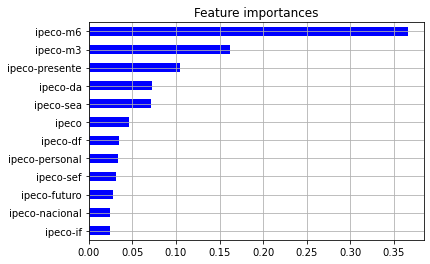

X_train shape: (203, 6) || X_test shape: (1, 6) || y_train shape: (203,)
['ipeco' 'ipeco-sea' 'ipeco-da' 'ipeco-presente' 'ipeco-m3' 'ipeco-m6']


In [30]:
model = RandomForestRegressor(random_state=123, n_estimators=100)
model.fit(X_train, y_train)

fimp = pd.Series(model.feature_importances_, index=X_train.columns)
sfimp = fimp.sort_values()
sfimp.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.grid()
plt.show()

n = int(len(sfimp)/2)
subset = sfimp[-n:].index
X_train, X_test, y_train = gen_X_train(subset)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))
print(X_train.columns.values)

In [31]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.5, 1.0],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

y_train_pred = searcher.best_estimator_.predict(X_train)
y_pred = searcher.best_estimator_.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[14:52:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 0.5, 'eta': 0.01, 'max_depth': 2, 'min_child_weight': 12, 'n_estimators': 100}


,CV_RMSE,RMSE,MAE,R2
IPECO,4.075,2.265,1.5063,0.7154


# IPEC

In [32]:
indice = 'IPEC'
X_train, X_test, y_train = gen_X_train(vipec)

X_train shape: (227, 12) || X_test shape: (1, 12) || y_train shape: (227,)


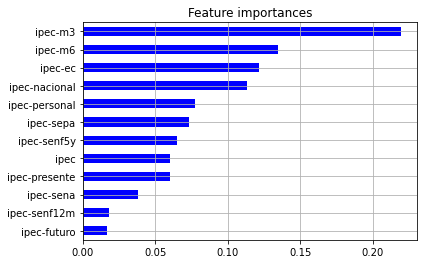

X_train shape: (227, 6) || X_test shape: (1, 6) || y_train shape: (227,)
['ipec-sepa' 'ipec-personal' 'ipec-nacional' 'ipec-ec' 'ipec-m6' 'ipec-m3']


In [33]:
model = RandomForestRegressor(random_state=123, n_estimators=100)
model.fit(X_train, y_train)

fimp = pd.Series(model.feature_importances_, index=X_train.columns)
sfimp = fimp.sort_values()
sfimp.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.grid()
plt.show()

n = int(len(sfimp)/2)
subset = sfimp[-n:].index
X_train, X_test, y_train = gen_X_train(subset)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))
print(X_train.columns.values)

In [34]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.5, 1.0],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

y_train_pred = searcher.best_estimator_.predict(X_train)
y_pred = searcher.best_estimator_.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[14:52:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 1.0, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 9, 'n_estimators': 100}


,CV_RMSE,RMSE,MAE,R2
IPECO,4.0750,2.2650,1.5063,0.7154
IPEC,4.0345,1.8905,1.3913,0.7891


# ICE

In [35]:
indice = 'ICE'
X_train, X_test, y_train = gen_X_train(vice)

X_train shape: (192, 16) || X_test shape: (1, 16) || y_train shape: (192,)


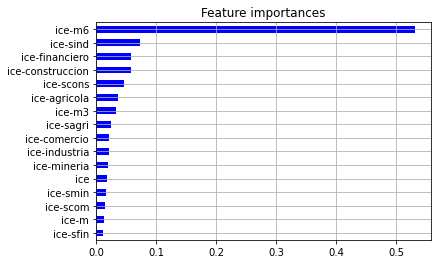

X_train shape: (192, 8) || X_test shape: (1, 8) || y_train shape: (192,)
['ice-sagri' 'ice-m3' 'ice-agricola' 'ice-scons' 'ice-construccion'
 'ice-financiero' 'ice-sind' 'ice-m6']


In [36]:
model = RandomForestRegressor(random_state=123, n_estimators=100)
model.fit(X_train, y_train)

fimp = pd.Series(model.feature_importances_, index=X_train.columns)
sfimp = fimp.sort_values()
sfimp.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.grid()
plt.show()

n = int(len(sfimp)/2)
subset = sfimp[-n:].index
X_train, X_test, y_train = gen_X_train(subset)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))
print(X_train.columns.values)

In [37]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.5, 1.0],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

y_train_pred = searcher.best_estimator_.predict(X_train)
y_pred = searcher.best_estimator_.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[14:52:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 0.5, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 12, 'n_estimators': 100}


,CV_RMSE,RMSE,MAE,R2
IPECO,4.0750,2.2650,1.5063,0.7154
IPEC,4.0345,1.8905,1.3913,0.7891
ICE,3.6711,1.5614,1.0365,0.8680


# IMCE

In [38]:
indice = 'IMCE'
X_train, X_test, y_train = gen_X_train(vimce)

X_train shape: (207, 12) || X_test shape: (1, 12) || y_train shape: (207,)


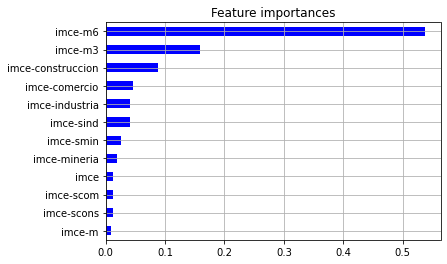

X_train shape: (207, 6) || X_test shape: (1, 6) || y_train shape: (207,)
['imce-sind' 'imce-industria' 'imce-comercio' 'imce-construccion'
 'imce-m3' 'imce-m6']


In [39]:
model = RandomForestRegressor(random_state=123, n_estimators=100)
model.fit(X_train, y_train)

fimp = pd.Series(model.feature_importances_, index=X_train.columns)
sfimp = fimp.sort_values()
sfimp.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.grid()
plt.show()

n = int(len(sfimp)/2)
subset = sfimp[-n:].index
X_train, X_test, y_train = gen_X_train(subset)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))
print(X_train.columns.values)

In [40]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.5, 1.0],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

y_train_pred = searcher.best_estimator_.predict(X_train)
y_pred = searcher.best_estimator_.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[14:53:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 0.5, 'eta': 0.01, 'max_depth': 2, 'min_child_weight': 9, 'n_estimators': 100}


,CV_RMSE,RMSE,MAE,R2
IPECO,4.0750,2.2650,1.5063,0.7154
IPEC,4.0345,1.8905,1.3913,0.7891
ICE,3.6711,1.5614,1.0365,0.8680
IMCE,3.5854,1.7170,1.1939,0.8403


# Confianza de los consumidores

In [41]:
indice = 'Consumidores'
X_train, X_test, y_train = gen_X_train(vconsumidores)

X_train shape: (203, 24) || X_test shape: (1, 24) || y_train shape: (203,)


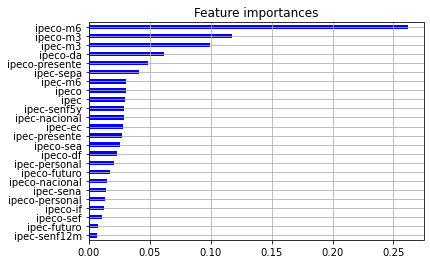

X_train shape: (203, 12) || X_test shape: (1, 12) || y_train shape: (203,)
['ipec-ec' 'ipec-nacional' 'ipec-senf5y' 'ipec' 'ipeco' 'ipec-m6'
 'ipec-sepa' 'ipeco-presente' 'ipeco-da' 'ipec-m3' 'ipeco-m3' 'ipeco-m6']


In [42]:
model = RandomForestRegressor(random_state=123, n_estimators=100)
model.fit(X_train, y_train)

fimp = pd.Series(model.feature_importances_, index=X_train.columns)
sfimp = fimp.sort_values()
sfimp.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.grid()
plt.show()

n = int(len(sfimp)/2)
subset = sfimp[-n:].index
X_train, X_test, y_train = gen_X_train(subset)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))
print(X_train.columns.values)

In [43]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.5, 1.0],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

y_train_pred = searcher.best_estimator_.predict(X_train)
y_pred = searcher.best_estimator_.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[14:53:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 1.0, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 9, 'n_estimators': 100}


,CV_RMSE,RMSE,MAE,R2
IPECO,4.0750,2.2650,1.5063,0.7154
IPEC,4.0345,1.8905,1.3913,0.7891
ICE,3.6711,1.5614,1.0365,0.8680
IMCE,3.5854,1.7170,1.1939,0.8403
Consumidores,4.0461,1.0722,0.7614,0.9362


# Confianza empresarial

In [44]:
indice = 'Empresarios'
X_train, X_test, y_train = gen_X_train(vempresarios)

X_train shape: (192, 28) || X_test shape: (1, 28) || y_train shape: (192,)


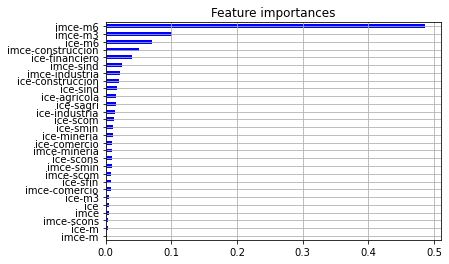

X_train shape: (192, 14) || X_test shape: (1, 14) || y_train shape: (192,)
['ice-smin' 'ice-scom' 'ice-industria' 'ice-sagri' 'ice-agricola'
 'ice-sind' 'ice-construccion' 'imce-industria' 'imce-sind'
 'ice-financiero' 'imce-construccion' 'ice-m6' 'imce-m3' 'imce-m6']


In [45]:
model = RandomForestRegressor(random_state=123, n_estimators=100)
model.fit(X_train, y_train)

fimp = pd.Series(model.feature_importances_, index=X_train.columns)
sfimp = fimp.sort_values()
sfimp.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.grid()
plt.show()

n = int(len(sfimp)/2)
subset = sfimp[-n:].index
X_train, X_test, y_train = gen_X_train(subset)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))
print(X_train.columns.values)

In [46]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.5, 1.0],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

y_train_pred = searcher.best_estimator_.predict(X_train)
y_pred = searcher.best_estimator_.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[14:53:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 0.5, 'eta': 0.01, 'max_depth': 2, 'min_child_weight': 9, 'n_estimators': 100}


,CV_RMSE,RMSE,MAE,R2
IPECO,4.0750,2.2650,1.5063,0.7154
IPEC,4.0345,1.8905,1.3913,0.7891
ICE,3.6711,1.5614,1.0365,0.8680
IMCE,3.5854,1.7170,1.1939,0.8403
Consumidores,4.0461,1.0722,0.7614,0.9362
Empresarios,3.7404,1.5477,1.0681,0.8703


# Todos los índices

In [47]:
indice = 'Todos'
X_train, X_test, y_train = gen_X_train(X_train0.columns)

X_train shape: (192, 52) || X_test shape: (1, 52) || y_train shape: (192,)


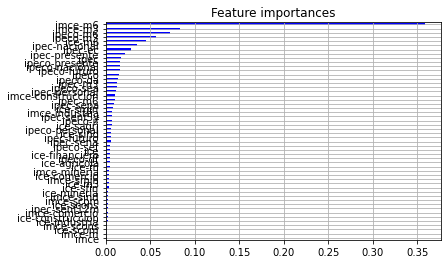

X_train shape: (196, 26) || X_test shape: (1, 26) || y_train shape: (196,)
['ipeco-personal' 'ice-sagri' 'ipeco-if' 'ipec-senf5y' 'imce-industria'
 'ice-smin' 'ipec-sepa' 'ipec-m6' 'imce-construccion' 'ipec-personal'
 'ipeco-sea' 'ipec-m3' 'ipeco-da' 'ipeco' 'ipeco-futuro' 'ipeco-nacional'
 'ipeco-presente' 'ipec' 'ipec-presente' 'ipec-ec' 'ipec-nacional'
 'ice-m6' 'ipeco-m3' 'ipeco-m6' 'imce-m3' 'imce-m6']


In [48]:
model = RandomForestRegressor(random_state=123, n_estimators=100)
model.fit(X_train, y_train)

fimp = pd.Series(model.feature_importances_, index=X_train.columns)
sfimp = fimp.sort_values()
sfimp.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.grid()
plt.show()

n = int(len(sfimp)/2)
subset = sfimp[-n:].index
X_train, X_test, y_train = gen_X_train(subset)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))
print(X_train.columns.values)

In [49]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.5, 1.0],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

y_train_pred = searcher.best_estimator_.predict(X_train)
y_pred = searcher.best_estimator_.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[14:53:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 1.0, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 12, 'n_estimators': 100}


,CV_RMSE,RMSE,MAE,R2
IPECO,4.0750,2.2650,1.5063,0.7154
IPEC,4.0345,1.8905,1.3913,0.7891
ICE,3.6711,1.5614,1.0365,0.8680
IMCE,3.5854,1.7170,1.1939,0.8403
Consumidores,4.0461,1.0722,0.7614,0.9362
Empresarios,3.7404,1.5477,1.0681,0.8703
Todos,3.2915,0.7615,0.5578,0.9685


# Evaluación según resultados en CV y train set

In [50]:
samples

,rows,cols
IPECO,203,6
IPEC,227,6
ICE,192,8
IMCE,207,6
Consumidores,203,12
Empresarios,192,14
Todos,196,26


In [51]:
results['Ratio'] = (results['CV_RMSE'] / results['RMSE']).round(2)
print('Best models:')
print(results[['CV_RMSE', 'RMSE', 'MAE', 'Ratio']].idxmin(), '\n')
print('Best R2:')
print(results[['R2']].idxmax(), '\n')
results.round(2)

Best models:
CV_RMSE    Todos
RMSE       Todos
MAE        Todos
Ratio      IPECO
dtype: object 

Best R2:
R2    Todos
dtype: object 



,CV_RMSE,RMSE,MAE,R2,Ratio
IPECO,4.08,2.27,1.51,0.72,1.80
IPEC,4.03,1.89,1.39,0.79,2.13
ICE,3.67,1.56,1.04,0.87,2.35
IMCE,3.59,1.72,1.19,0.84,2.09
Consumidores,4.05,1.07,0.76,0.94,3.77
Empresarios,3.74,1.55,1.07,0.87,2.42
Todos,3.29,0.76,0.56,0.97,4.32


In [59]:
predicciones = predicciones.reset_index()
predicciones.columns = ['percepcion', 'prediccion']
predicciones.round(2)

ValueError: Length mismatch: Expected axis has 3 elements, new values have 2 elements

In [53]:
print('Mayor predicción:')
print(predicciones['prediccion'].idxmax(), '\n')

print('Menor predicción:')
print(predicciones['prediccion'].idxmin(), '\n')

Mayor predicción:
5 

Menor predicción:
4 



In [54]:
print('Predicción de la encuesta de expectativas económicas:')
pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/BC%20EEE%20PIB%20e%20IMACEC.csv', index_col='Fecha')['IMACEC un mes atrás'].tail(1)

Predicción de la encuesta de expectativas económicas:


Fecha
01-08-2021    16.3
Name: IMACEC un mes atrás, dtype: float64

In [55]:
predicciones.to_csv('pred_2021_08.csv', index=False)